In [32]:
import numpy as np
import scipy as sci
import networkx as nx
import sklearn
from sklearn.covariance import GraphicalLassoCV
import random
import matplotlib.pyplot as plt
import gglasso
from gglasso.problem import glasso_problem
from matplotlib import animation


## Network sampling from Banner covariance samples

In [3]:
cov = np.array([[[ 1.10792458,  .620366498,  .172131363],
  [ .620366498 , 2.02438732 , 2.66024718],
  [ .172131363 , 2.66024718 , 6.10096368]],[[ 0.3,  -.657985912,  .240694407],
  [ .657985912,  4.86813079  ,4.34450433],
  [ .240694407,  4.34450433,  8.42315797]]])


def partial_correlations(K):
    '''
    param K: RxTxDxD matrix of covariances
            R: number of samples
            T: number of time steps
            D: number of output dimensions
    returns par_cor: RxTxDxD  partial correlation matrix 
    '''
    par_cor = np.ones_like(K)
    
    
    n_sample = K.shape[0]
    n_time=K.shape[1]
    n_dim = K.shape[2]
    for s in range(n_sample):
        for t in range(n_time):
            for i in range(n_dim):
                for j in range(i+1, n_dim):
                    if i != j:
                        par_cor[s,t,i,j] = -K[s,t,i,j]/(np.sqrt(K[s,t,i,i])*np.sqrt(K[s,t,j,j]))
                        par_cor[s,t,j,i] = par_cor[s,t,i,j]
    return par_cor
        
def compute_networks(sigma, symptoms):
    precision = np.linalg.inv(sigma)
    edges = partial_correlations(precision)
    edge_mean = np.mean(edges, axis=0)
    edge_var = np.var(edges, axis=0)
    return edge_mean, edge_var

def prune_edges(edge_mean, edge_var):
    '''
    prunes edges when 0 is within the 95% confidence interval. 
    param edge_mean: TxDxD
    param edge_var: TxDxD
    return: pruned edges
    '''
    pruned_edges = np.copy(edge_mean)
    T,D,_ = edge_mean.shape
    condition_upperb = edge_mean + 1.96*edge_var > 0
    condition_lowerb = edge_mean - 1.96*edge_var < 0 

    condition  = condition_lowerb & condition_upperb
    pruned_edges[condition] = 0
    return pruned_edges
    

Y = np.array([[0.2,4,1.1],[1.1,4,1.3]])
Y = np.reshape(Y, (2,1,3))
edge_mean, edge_var = compute_networks(np.reshape(cov,(2,1,3,3)), Y)

edges_pruned = prune_edges(edge_mean, edge_var)



## LASSO FOR MGARCH AND MOGP



In [48]:
#gglasso defines the glasso problem to be solved.
# the regularisation paramter is the parameter lambda that defines how strict the algorithm is in 
# rejecting edges. To find the ideal value for lambda, ebic based-optimization is used.
# ebic has one parameter, gamma, that needs to be chosen manually. Usually the value 0.5 is good
# this selects a lasso model. 

P =  glasso_problem(cov[0], 1, reg_params = {'lambda1': 0.05}, latent = False, do_scaling = False)
lambda1_range = np.logspace(0, -3, 30)
modelselect_params = {'lambda1_range': lambda1_range}

P.model_selection(modelselect_params = modelselect_params, method = 'eBIC', gamma = 0.1)
# regularization parameters are set to the best ones found during model selection

sol = P.solution.precision_

# calculates the unweigthed edges. Perhaps useful if we want thet edges to be binary.

P.solution.calc_adjacency(t = 0.1)
adj = P.solution.adjacency_
print(sol)
print(adj)

ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 48 iterations with status: optimal.
ADMM terminated after 45 iterations with status: optimal.
ADMM terminated after 85 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 10 i

In [3]:
#iterating through different values of alpha/gamma (tuning parameter)
for _,num in enumerate(np.linspace(0,0.5,10)):
    sparse_cov, sparse_prec = sklearn.covariance.graphical_lasso(cov[0], alpha = num)
    print(f"sparse {num}\n", sparse_prec)
    #print("regular num", np.linalg.inv(cov[0]))
    edge_mean, _ =compute_networks(np.reshape(sparse_cov,(1,1,3,3)), Y)
    print(f"partial cor {num}\n", edge_mean)

sparse 0.0
 [[ 1.31741131 -0.83107537  0.32521061]
 [-0.83107537  1.68111965 -0.70958293]
 [ 0.32521061 -0.70958293  0.46413766]]
partial cor 0.0
 [[[ 1.          0.558445   -0.41589204]
  [ 0.558445    1.          0.80330494]
  [-0.41589204  0.80330494  1.        ]]]
sparse 0.05555555555555555
 [[ 1.16307426 -0.59609976  0.21108623]
 [-0.59609976  1.40154554 -0.57612574]
 [ 0.21108623 -0.57612574  0.40199687]]
partial cor 0.05555555555555555
 [[[ 1.          0.46688124 -0.30870278]
  [ 0.46688124  1.          0.76753596]
  [-0.30870278  0.76753596  1.        ]]]
sparse 0.1111111111111111
 [[ 1.06894914 -0.43559386  0.1323735 ]
 [-0.43559386  1.21991744 -0.48949656]
 [ 0.1323735  -0.48949656  0.36228695]]
partial cor 0.1111111111111111
 [[[ 1.          0.38144609 -0.21271218]
  [ 0.38144609  1.          0.73629975]
  [-0.21271218  0.73629975  1.        ]]]
sparse 0.16666666666666666
 [[ 1.00983046 -0.31667521  0.07335272]
 [-0.31667521  1.09411356 -0.42960225]
 [ 0.07335272 -0.42960225

## VISUALISATION


(1, 3, 3)

Random Layout:


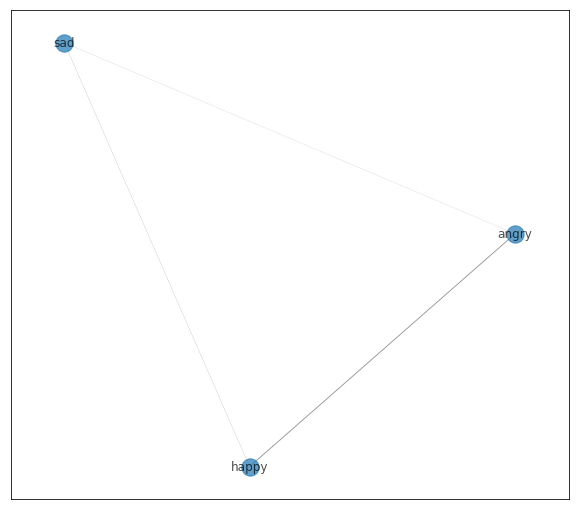

In [27]:
#animate the networks
#needs matplotlib 2.2
def create_graph(edges, nodes):
    graph = nx.Graph()
    number_nodes = nodes.shape[0]
    edge_list = []
    for a in range(number_nodes):
        graph.add_node(nodes[a])
        for b in range(a,number_nodes):
            if (edges[a,b]> 0.05) or (edges[a,b]< -0.05):
                edge_list.append((nodes[a], nodes[b], edges[a,b]))
    graph.add_weighted_edges_from(edge_list)
    return graph

print(edge_mean.shape)
my_graph = create_graph(edge_mean[0,:,:],  np.array(['sad','happy','angry']))

#draw the size of the node depending of the severity of the symptoms?
#node_size = [0.0005 * nx.get_node_attributes(G, 'population')[v] for v in G]

#adjust edge width depending on the weigth
print(my_graph)
edge_width = [ 1.3*my_graph[u][v]['weight'] for u, v in my_graph.edges()]
  
plt.figure(figsize =(10, 9))
pos = nx.random_layout(my_graph)
print("Random Layout:")
  
# demonstrating random layout
nx.draw_networkx(my_graph, pos, alpha = 0.7, 
                 with_labels = True,  width = edge_width,
                 edge_color ='.4', cmap = plt.cm.Blues)





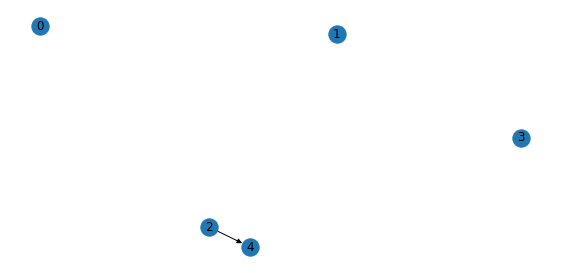

In [39]:
# this is an animation for displaying dynamic networks
from matplotlib import pyplot as plt, animation
import networkx as nx
import random

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()

G = nx.DiGraph()
G.add_nodes_from([0, 1, 2, 3, 4])

nx.draw(G, with_labels=True)

def animate(frame):
    fig.clear()
    num1 = random.randint(0, 4)
    num2 = random.randint(0, 4)
    G.add_edges_from([(num1, num2)])
    nx.draw(G, with_labels=True)

ani = animation.FuncAnimation(fig, animate, frames=6, interval=1000, repeat=True)

plt.show()